# Kickstarter Projects
# Day 2 Homework for a Machine Learning Course (Appendix-2)
Author：Hiroki Miyamoto

# Links to my homeworks
- Kaggle
    - Day1
        - Objective of Day 1 : Build a supervised machine learning model based on the lecture on Day 1. Don't care about the accuracy for now.
        - https://www.kaggle.com/hmiyamoto/day-1-homework-for-a-machine-learning-course/
    - Day2
        - Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.
        - https://www.kaggle.com/hmiyamoto/day-2-homework-for-a-machine-learning-course/
    - Day2 Appendix-1
        - Check the contribution of explanatory variables for prediction by investigating the weight
        - https://www.kaggle.com/hmiyamoto/day-2-homework-appendix-1
- GitHub
    - https://github.com/hmiyamoto1/skillupai_ml

## Objective of Day 2 : Improve the accuracy of your supervised machine learning model applying the algorithms introduced on Day 2.

# In this notebook Day 2 Appendix-2, "backers" and "usd_pledged_real" are removed from explanatory variables for success prediction because these variables are results of funding.

### Table of Contents (Day 2 Appendix-2)
1. Check the contribution of explanatory variables for prediction by investigating the weight
1. Visualization of the highly-contribution variables

# Summary
## 2-variables 'category_dummy' and 'usd_goal_real_log10' were highly contributed to predict results of funding.


- Variables
    - Objective variable
        - state_dummy (successful = 1, other = 0)
    - Explanatory variables
        - ~~**backers_log10**~~
            - **removed because this variable describes results of funding**
        - ~~**usd_pledged_real_log10**~~
            - **removed because this variable describes results of funding**
        - usd_goal_real_log10
        - category_dummy
        - currency_dummy
        - time_campaign_dummy
- Model
    - Logistic regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - L1 Reguralization is applied.
        - alpha = 1e-4 is fixed.
    - Normalization is applied.
- **Result**
    - **All 4-variables are used**
        - **Cross Validation Log-likelihood = -10.734**
        - **Cross Validation Accuracy = 68.922%**
- **Examination Summary**
    - **2-variables 'category_dummy' and 'usd_goal_real_log10' were highly contributed to predict.**
    - **Only these 2-variables can predict success or not with 68.610% accuracy.**
        - **Only 'category_dummy' can predict success or not with 67.468% accuracy.**
        - **Only 'usd_goal_real_log10' can predict success or not with 64.781% accuracy.**
    - **Weights interpretation**
        - **w0 = -0.689**
            - **Kickstarters are basically difficult to success to get funding.**
                - **Remember the success rate was only 35%. Weight w0 agrees with this fact.**
        - **usd_goal_real_log10, w1 = -0.433**
            - **The more money kickstarters required, the more difficult to reach full amount funding.**
        - **category_dummy, w2 = 0.620**
            - **Success rate highly depend on what category a kickstarter is in.**
                - **category_dummy is created by aggregating success rates of each category from training data.**

# 0. Preparation

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Acquire data

In [2]:
df_kick = pd.read_csv("../input/ks-projects-201801.csv")

## Preview the data

In [3]:
display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Create dataframe with selected features

- Objective variable
    - state_dummy (successful = 1, other = 0)
- Explanatory variables
    - ~~**backers_log10**~~
        - **removed because this variable describes results of funding**
    - ~~**usd_pledged_real_log10**~~
        - **removed because this variable describes results of funding**
    - usd_goal_real_log10
    - category_dummy
    - currency_dummy
    - time_campaign_dummy

In [4]:
df_kick['launched'] = pd.to_datetime(df_kick['launched'])
df_kick['laun_month_year'] = df_kick['launched'].dt.to_period("M")
df_kick['laun_year'] = df_kick['launched'].dt.to_period("A")
df_kick['laun_hour'] = df_kick['launched'].dt.hour

df_kick['deadline'] = pd.to_datetime(df_kick['deadline'])
df_kick['dead_month_year'] = df_kick['deadline'].dt.to_period("M")
df_kick['dead_year'] = df_kick['launched'].dt.to_period("A")

#Creating a new columns with Campaign total months
df_kick['time_campaign'] = df_kick['dead_month_year'] - df_kick['laun_month_year']
df_kick['time_campaign'] = df_kick['time_campaign'].astype(int)

df_kick['time_campaign_dummy'] = df_kick['time_campaign']
df_kick['time_campaign_dummy'].loc[df_kick['time_campaign_dummy'] >= 5] = 5

display(df_kick.head())

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd pledged,usd_pledged_real,usd_goal_real,laun_month_year,laun_year,laun_hour,dead_month_year,dead_year,time_campaign,time_campaign_dummy
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,0.0,1533.95,2015-08,2015,12,2015-10,2015,2,2
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,100.0,2421.0,30000.00,2017-09,2017,4,2017-11,2017,2,2
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,220.0,220.0,45000.00,2013-01,2013,0,2013-02,2013,1,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,1.0,1.0,5000.00,2012-03,2012,3,2012-04,2012,1,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,1283.0,1283.0,19500.00,2015-07,2015,8,2015-08,2015,1,1


In [5]:
df_kick['state_dummy'] = df_kick['state']
df_kick['state_dummy'].loc[df_kick['state_dummy'] != 'successful'] = 0
df_kick['state_dummy'].loc[df_kick['state_dummy'] == 'successful'] = 1

# display(df_kick.head())

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# epsilon = 1e-8
epsilon = 1

# df_kick['backers_log10'] = np.log10(df_kick['backers'] + epsilon)
# df_kick['usd_pledged_real_log10'] = np.log10(df_kick['usd_pledged_real'] + epsilon)
df_kick['usd_goal_real_log10'] = np.log10(df_kick['usd_goal_real'] + epsilon)

display(df_kick.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_goal_real,laun_month_year,laun_year,laun_hour,dead_month_year,dead_year,time_campaign,time_campaign_dummy,state_dummy,usd_goal_real_log10
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,1533.95,2015-08,2015,12,2015-10,2015,2,2,0,3.186094
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,30000.00,2017-09,2017,4,2017-11,2017,2,2,0,4.477136
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,45000.00,2013-01,2013,0,2013-02,2013,1,1,0,4.653222
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,5000.00,2012-03,2012,3,2012-04,2012,1,1,0,3.699057
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,19500.00,2015-07,2015,8,2015-08,2015,1,1,0,4.290057


# 1. Check the contribution of explanatory variables for prediction by investigating the weight
- Variables
    - Objective variable
        - state_dummy (successful = 1, other = 0)
    - Explanatory variables
        - ~~**backers_log10**~~
            - **removed because this variable describes results of funding**
        - ~~**usd_pledged_real_log10**~~
            - **removed because this variable describes results of funding**
        - usd_goal_real_log10
        - category_dummy
        - currency_dummy
        - time_campaign_dummy
- Model
    - The same model as Day 1
        - Linear regression
    - Cross validation (Train:80%/Test:20% - 5 times) is applied.
    - L1 Reguralization is applied.
        - alpha = 1e-4 is fixed.
    - Normalization is applied.
- **Result**
    - **All 4-variables are used**
        - **Cross Validation Log-likelihood = -10.734**
        - **Cross Validation Accuracy = 68.922%**
- **Examination Summary**
    - **2-variables 'category_dummy' and 'usd_goal_real_log10' are highly contributed to predict.**
    - **Only these 2-variables can predict success or not with 68.610% accuracy.**
        - **Only 'category_dummy' can predict success or not with 67.468% accuracy.**
        - **Only 'usd_goal_real_log10' can predict success or not with 64.781% accuracy.**
    - **Weights interpretation**
        - **w0 = -0.689**
            - **Kickstarters are basically difficult to success to get funding.**
                - **Remember the success rate was only 35%. Weight w0 agrees with this fact.**
        - **usd_goal_real_log10, w1 = -0.433**
            - **The more money kickstarters required, the more difficult to reach full amount funding.**
        - **category_dummy, w2 = 0.620**
            - **Success rate highly depend on what category a kickstarter is in.**
                - **category_dummy is created by aggregating success rates of each category from training data.**

## L1 alpha=1e-4, normalization, 4-variables
- Variables
    - Objective variable
        - state_dummy (successful = 1, other = 0)
    - Explanatory variables and weights(fold 1)
        - w0 = -0.698
        - **usd_goal_real_log10, w1 = -0.413**
        - **category_dummy, w2 = 0.611**
        - currency_dummy, w3 = 0.132
        - time_campaign_dummy, w4 = -0.157
    - **It seems 'category_dummy' and 'usd_goal_real_log10' highly contribute to the prediction accuracy.**
- Result
    - **4-variables are used**
        - **Cross Validation Log-likelihood = -10.734**
        - **Cross Validation Accuracy = 68.922%**

In [7]:
penalty = 'l1'
alpha = 1e-4

y = df_kick["state_dummy"].values
X = df_kick[["usd_goal_real_log10", "category", "currency", "time_campaign_dummy"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["usd_goal_real_log10", "category", "currency", "time_campaign_dummy"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

    # Create dummy variables for currency using train data
    # Replace currency to currency_success_rate
    currency_success_rate = {}
    df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
    df_currency_all_count = df_X_train['currency'].value_counts()
    for currency in df_currency_all_count.keys():
        currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
    df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
    df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

    X_train = df_X_train[["usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    X_test = df_X_test[["usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    
    
    clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train_stand, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
    w2 = clf.coef_[0, 1]
    w3 = clf.coef_[0, 2]
    w4 = clf.coef_[0, 3]
    print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}'.format(w0, w1, w2, w3, w4))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae 
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -0.698, w1 = -0.413, w2 = 0.611, w3 = 0.132, w4 = -0.157
Log-likelihood = -10.706
Accuracy = 69.003%

Fold 2
w0 = -0.694, w1 = -0.422, w2 = 0.602, w3 = 0.136, w4 = -0.159
Log-likelihood = -10.763
Accuracy = 68.839%

Fold 3
w0 = -0.680, w1 = -0.427, w2 = 0.603, w3 = 0.120, w4 = -0.174
Log-likelihood = -10.750
Accuracy = 68.877%

Fold 4
w0 = -0.686, w1 = -0.435, w2 = 0.603, w3 = 0.126, w4 = -0.176
Log-likelihood = -10.747
Accuracy = 68.884%

Fold 5
w0 = -0.685, w1 = -0.433, w2 = 0.604, w3 = 0.140, w4 = -0.170
Log-likelihood = -10.705
Accuracy = 69.006%

Cross Validation Log-likelihood = -10.734
Cross Validation Accuracy = 68.922%


## L1 alpha=1e-4, normalization, 2-highly-contributed-variables
- Variables
    - Objective variable
        - state_dummy (successful = 1, other = 0)
    - Explanatory variables and weights(fold 1)
        - **w0 = -0.689**
            - **Kickstarters are basically difficult to success to get funding.**
                - **Remember the success rate was only 35%. Weight w0 agrees with this fact.**
        - **usd_goal_real_log10, w1 = -0.433**
            - **The more money kickstarters required, the more difficult to reach full amount funding.**
        - **category_dummy, w2 = 0.620**
            - **Success rate highly depend on what category a kickstarter is in.**
                - **category_dummy is created by aggregating success rates of each category from training data.**
        - ~~currency_dummy~~
        - ~~time_campaign_dummy~~
- Result
    - 4-variables are used
        - Cross Validation Log-likelihood = -10.734
        - Cross Validation Accuracy = 68.922%
    - **2-highly-contributed-variables are used**
        - **Cross Validation Log-likelihood = -10.842**
        - **Cross Validation Accuracy = 68.610%**
            - **'category_dummy' and 'usd_goal_real_log10' can predict success or not with 68.610% accuracy.**

In [8]:
penalty = 'l1'
alpha = 1e-4

y = df_kick["state_dummy"].values
X = df_kick[["usd_goal_real_log10", "category"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["usd_goal_real_log10", "category"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["usd_goal_real_log10", "category"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

#     # Create dummy variables for currency using train data
#     # Replace currency to currency_success_rate
#     currency_success_rate = {}
#     df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
#     df_currency_all_count = df_X_train['currency'].value_counts()
#     for currency in df_currency_all_count.keys():
#         currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
#     df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
#     df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

    X_train = df_X_train[["usd_goal_real_log10", "category_dummy"]].values
    X_test = df_X_test[["usd_goal_real_log10", "category_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    
    
    clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train_stand, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
    w2 = clf.coef_[0, 1]
#     w3 = clf.coef_[0, 2]
#     w4 = clf.coef_[0, 3]
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}'.format(w0, w1, w2, w3, w4))
    print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))

#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae 
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


w0 = -0.689, w1 = -0.433, w2 = 0.620
Log-likelihood = -10.840
Accuracy = 68.615%

Fold 2
w0 = -0.688, w1 = -0.440, w2 = 0.609
Log-likelihood = -10.886
Accuracy = 68.482%

Fold 3
w0 = -0.674, w1 = -0.446, w2 = 0.609
Log-likelihood = -10.814
Accuracy = 68.691%

Fold 4
w0 = -0.681, w1 = -0.454, w2 = 0.610
Log-likelihood = -10.890
Accuracy = 68.469%

Fold 5
w0 = -0.679, w1 = -0.452, w2 = 0.612
Log-likelihood = -10.779
Accuracy = 68.791%

Cross Validation Log-likelihood = -10.842
Cross Validation Accuracy = 68.610%


## L1 alpha=1e-4, normalization, only first-highly-contributed-variables, "category_dummy" is applied
- Variables
    - Objective variable
        - state_dummy (successful = 1, other = 0)
    - Explanatory variables and weights(fold 1)
        - **w0 = -0.661**
            - **Kickstarters are basically difficult to success to get funding.**
                - **Remember the success rate was only 35%. Weight w0 agrees with this fact.**
        - **~~usd_goal_real_log10~~**
            - **~~The more money kickstarters required, the more difficult to reach full amount funding.~~**
        - **category_dummy, w1 = 0.661**
            - **Success rate highly depend on what category a kickstarter is in.**
                - **category_dummy is created by aggregating success rates of each category from training data.**
        - ~~currency_dummy~~
        - ~~time_campaign_dummy~~
- Result
    - 4-variables are used
        - Cross Validation Log-likelihood = -10.734
        - Cross Validation Accuracy = 68.922%
    - 2-highly-contributed-variables are used
        - Cross Validation Log-likelihood = -10.842
        - Cross Validation Accuracy = 68.610%
            - 'category_dummy' and 'usd_goal_real_log10' can predict success or not with 68.610% accuracy.
    - **Only first-highly-contributed-variables 'category_dummy' is used**
        - **Cross Validation Log-likelihood = -11.236**
        - **Cross Validation Accuracy = 67.468%**
            - **'category_dummy' can predict success or not with 67.468% accuracy.**

In [9]:
penalty = 'l1'
alpha = 1e-4

y = df_kick["state_dummy"].values
X = df_kick[["category"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["category"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["category"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




    # Create dummy variables for category using train data
    # Replace category to category_success_rate
    category_success_rate = {}
    df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
    df_category_all_count = df_X_train['category'].value_counts()
    for category in df_category_all_count.keys():
        category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
    df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
    df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

#     # Create dummy variables for currency using train data
#     # Replace currency to currency_success_rate
#     currency_success_rate = {}
#     df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
#     df_currency_all_count = df_X_train['currency'].value_counts()
#     for currency in df_currency_all_count.keys():
#         currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
#     df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
#     df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

#     X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
#     X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

#     X_train = df_X_train[["usd_pledged_real_log10", "usd_goal_real_log10"]].values
#     X_test = df_X_test[["usd_pledged_real_log10", "usd_goal_real_log10"]].values
    
    X_train = df_X_train[["category_dummy"]].values
    X_test = df_X_test[["category_dummy"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    
    
    clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train_stand, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
#     w2 = clf.coef_[0, 1]
#     w3 = clf.coef_[0, 2]
#     w4 = clf.coef_[0, 3]
#     w5 = clf.coef_[0, 4]
#     w6 = clf.coef_[0, 5]
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))
    print('w0 = {:.3f}, w1 = {:.3f}'.format(w0, w1))
    
#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae 
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1
w0 = -0.661, w1 = 0.661
Log-likelihood = -11.231
Accuracy = 67.483%

Fold 2
w0 = -0.662, w1 = 0.652
Log-likelihood = -11.283
Accuracy = 67.332%

Fold 3
w0 = -0.644, w1 = 0.653
Log-likelihood = -11.189
Accuracy = 67.606%

Fold 4
w0 = -0.650, w1 = 0.654
Log-likelihood = -11.331
Accuracy = 67.194%

Fold 5
w0 = -0.646, w1 = 0.656
Log-likelihood = -11.147
Accuracy = 67.727%

Cross Validation Log-likelihood = -11.236
Cross Validation Accuracy = 67.468%


## L1 alpha=1e-4, normalization, only second-highly-contributed-variables, "usd_goal_real_log10" is applied
- Variables
    - Objective variable
        - state_dummy (successful = 1, other = 0)
    - Explanatory variables and weights(fold 1)
        - **w0 = -0.638**
            - **Kickstarters are basically difficult to success to get funding.**
                - **Remember the success rate was only 35%. Weight w0 agrees with this fact.**
        - **usd_goal_real_log10, w1 = -0.488**
            - **The more money kickstarters required, the more difficult to reach full amount funding.**
        - **~~category_dummy~~**
            - **~~Success rate highly depend on what category a kickstarter is in.~~**
                - **~~category_dummy is created by aggregating success rates of each category from training data.~~**
        - ~~currency_dummy~~
        - ~~time_campaign_dummy~~
- Result
    - 4-variables are used
        - Cross Validation Log-likelihood = -10.734
        - Cross Validation Accuracy = 68.922%
    - 2-highly-contributed-variables are used
        - Cross Validation Log-likelihood = -10.842
        - Cross Validation Accuracy = 68.610%
            - 'category_dummy' and 'usd_goal_real_log10' can predict success or not with 68.610% accuracy.
    - **Only first-highly-contributed-variables 'category_dummy' is used**
        - **Cross Validation Log-likelihood = -11.236**
        - **Cross Validation Accuracy = 67.468%**
            - **'category_dummy' can predict success or not with 67.468% accuracy.**
    - **Only second-highly-contributed-variables 'usd_goal_real_log10' is used**
        - **Cross Validation Log-likelihood = -12.164**
        - **Cross Validation Accuracy = 64.781%**
            - **'usd_goal_real_log10' can predict success or not with 64.781% accuracy.**

In [10]:
penalty = 'l1'
alpha = 1e-4

y = df_kick["state_dummy"].values
X = df_kick[["usd_goal_real_log10"]].values

n_split = 5 # Number of group

cross_valid_log_likelihood = 0
cross_valid_accuracy = 0
split_num = 1

# Cross Validation
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] # Train data
    X_test, y_test = X[test_idx], y[test_idx]     # Test data

#     print(X_train.shape)
#     print(X_test.shape)
    df_X_train = pd.DataFrame(X_train,
                             columns=["usd_goal_real_log10"])
    df_y_train = pd.DataFrame(y_train,
                             columns=["state_dummy"])

    df_X_test = pd.DataFrame(X_test,
                             columns=["usd_goal_real_log10"])
    df_y_test = pd.DataFrame(y_test,
                             columns=["state_dummy"])




#     # Create dummy variables for category using train data
#     # Replace category to category_success_rate
#     category_success_rate = {}
#     df_category_successful_count = df_X_train['category'][df_y_train['state_dummy'] == 1].value_counts()
#     df_category_all_count = df_X_train['category'].value_counts()
#     for category in df_category_all_count.keys():
#         category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
#     df_X_train['category_dummy'] = df_X_train['category'].replace(category_success_rate)
#     df_X_test['category_dummy'] = df_X_test['category'].replace(category_success_rate)

#     # Create dummy variables for currency using train data
#     # Replace currency to currency_success_rate
#     currency_success_rate = {}
#     df_currency_successful_count = df_X_train['currency'][df_y_train['state_dummy'] == 1].value_counts()
#     df_currency_all_count = df_X_train['currency'].value_counts()
#     for currency in df_currency_all_count.keys():
#         currency_success_rate[currency] = df_currency_successful_count[currency] / df_currency_all_count[currency]
#     df_X_train['currency_dummy'] = df_X_train['currency'].replace(currency_success_rate) 
#     df_X_test['currency_dummy'] = df_X_test['currency'].replace(currency_success_rate) 


#     display(df_X_train.head())
#     display(df_y_train.head())

#     display(df_X_test.head())
#     display(df_y_test.head())


    print("Fold %s"%split_num)

#     X_train = df_X_train[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values
#     X_test = df_X_test[["backers_log10", "usd_pledged_real_log10", "usd_goal_real_log10", "category_dummy", "currency_dummy", "time_campaign_dummy"]].values

#     X_train = df_X_train[["usd_pledged_real_log10", "usd_goal_real_log10"]].values
#     X_test = df_X_test[["usd_pledged_real_log10", "usd_goal_real_log10"]].values
    
    X_train = df_X_train[["usd_goal_real_log10"]].values
    X_test = df_X_test[["usd_goal_real_log10"]].values
    
    # Normaliztion
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    
    
    clf = SGDClassifier(loss='log', penalty=penalty, alpha=alpha, max_iter=100, fit_intercept=True, random_state=1234)
    clf.fit(X_train_stand, y_train)

    # Weight
    w0 = clf.intercept_[0]
    w1 = clf.coef_[0, 0]
#     w2 = clf.coef_[0, 1]
#     w3 = clf.coef_[0, 2]
#     w4 = clf.coef_[0, 3]
#     w5 = clf.coef_[0, 4]
#     w6 = clf.coef_[0, 5]
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))
#     print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}'.format(w0, w1, w2))
    print('w0 = {:.3f}, w1 = {:.3f}'.format(w0, w1))
    
#         plt.plot(np.abs(clf.coef_.T), marker='o')


    # Predict labels
    y_est_test = clf.predict(X_test_stand)

    # Log-likelihood
    log_likelihood = - log_loss(y_test, y_est_test)    
    cross_valid_log_likelihood += log_likelihood    
    print('Log-likelihood = {:.3f}'.format(log_likelihood))

    # Accuracy
    accuracy = accuracy_score(y_test, y_est_test)
    cross_valid_accuracy += accuracy   
    print('Accuracy = {:.3f}%'.format(100 * accuracy))
    print()

#     cross_valid_mae += mae 
    split_num += 1

# Generalization performance
final_log_likelihood = cross_valid_log_likelihood / n_split
print("Cross Validation Log-likelihood = %s"%round(final_log_likelihood, 3))
final_accuracy = cross_valid_accuracy / n_split
print('Cross Validation Accuracy = {:.3f}%'.format(100 * final_accuracy))
    

    

Fold 1
w0 = -0.638, w1 = -0.488
Log-likelihood = -12.269
Accuracy = 64.479%

Fold 2
w0 = -0.637, w1 = -0.499
Log-likelihood = -12.145
Accuracy = 64.837%

Fold 3
w0 = -0.625, w1 = -0.505
Log-likelihood = -12.108
Accuracy = 64.945%

Fold 4
w0 = -0.633, w1 = -0.512
Log-likelihood = -12.193
Accuracy = 64.698%

Fold 5
w0 = -0.632, w1 = -0.508
Log-likelihood = -12.108
Accuracy = 64.945%

Cross Validation Log-likelihood = -12.164
Cross Validation Accuracy = 64.781%


# 2.Visualization of the highly-contribution variables

In [11]:
# Create dummy variables for category using train data
# Replace category to category_success_rate
category_success_rate = {}
df_category_successful_count = df_kick['category'][df_kick['state_dummy'] == 1].value_counts()
df_category_all_count = df_kick['category'].value_counts()
for category in df_category_all_count.keys():
    category_success_rate[category] = df_category_successful_count[category] / df_category_all_count[category]
df_kick['category_dummy'] = df_kick['category'].replace(category_success_rate)

df_kick_2var = df_kick[["state_dummy", "category_dummy", "usd_goal_real_log10"]]


x = df_kick_2var[["category_dummy", "usd_goal_real_log10"]].values #returns a numpy array
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_kick_2var = pd.DataFrame(x_scaled)
df_kick_2var = pd.concat([df_kick[["state_dummy"]], df_kick_2var], axis=1)

df_kick_2var.columns = ["state_dummy", "category_dummy", "usd_goal_real_log10"]
# df_kick_2var["state_dummy"] = df_kick_2var["state_dummy"].astype(str)
# df_kick_2var.info()

As can be seen the figure below, state can be roughly separated by these 2-variables.

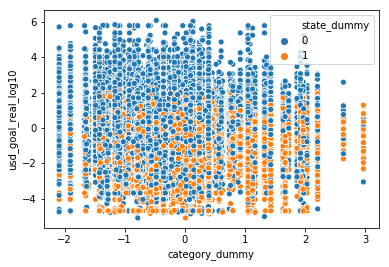

In [12]:
ax = sns.scatterplot(x="category_dummy", y="usd_goal_real_log10", hue="state_dummy", data=df_kick_2var)

<class 'seaborn.axisgrid.PairGrid'>


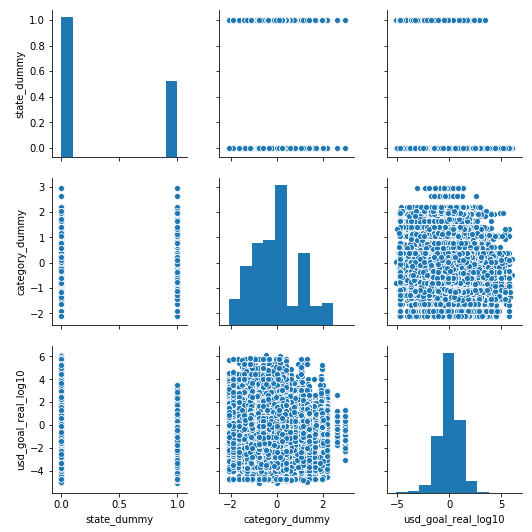

In [13]:
pg = sns.pairplot(df_kick_2var)
print(type(pg))

As can be seen the figures below, state can be better separated by "usd_pledged_real_log10" than "usd_goal_real_log10".

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


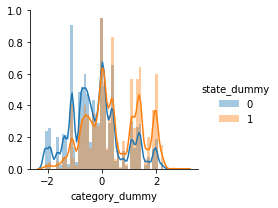

In [14]:
g = sns.FacetGrid(df_kick_2var, hue='state_dummy')
g.map(sns.distplot, "category_dummy", label="state_dummy")
g.add_legend()
plt.show()

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


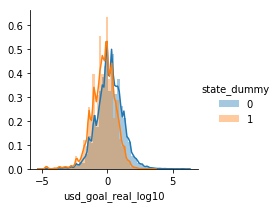

In [15]:
g = sns.FacetGrid(df_kick_2var, hue='state_dummy')
g.map(sns.distplot, "usd_goal_real_log10", label="state_dummy")
g.add_legend()
plt.show()